In [ ]:
import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
from xrspatial import zonal_stats
# from rasterstats import raster_stats
from geocube.api.core import make_geocube
import rioxarray
from shapely.geometry import box
import numpy as np

: 

In [2]:
vhm = rioxarray.open_rasterio('dados/0-VHM-sao-paulo-city-1m-8bits.tif')
vhm_100 = rioxarray.open_rasterio('dados/0-VHM-sao-paulo-city-1m-8bits-raio-100m.tif')
vhm_1000 = rioxarray.open_rasterio('dados/0-VHM-sao-paulo-city-1m-8bits-raio-1000m.tif')

In [3]:
results = []

for l in glob.glob('dados/lotes/*.zip'):

    print(os.path.splitext(os.path.basename(l))[0])
    gdf_lote = gpd.read_file(f'{l}!{os.path.splitext(os.path.basename(l))[0]}')
    gdf_lote["sqlc"] = gdf_lote.lo_setor + gdf_lote.lo_quadra + gdf_lote.lo_lote + gdf_lote.lo_condomi
    gdf_lote = gdf_lote.loc[gdf_lote.lo_tp_lote == 'F', ["sqlc", "geometry"]]
    gdf_lote = gdf_lote.reset_index().rename(columns = {'index':'indice'})
    # gdf_lote.indice = gdf_lote.indice + 1

    gdf_lote_bb = gpd.GeoDataFrame(
        geometry=[box(*list(gdf_lote.geometry.total_bounds))],
        crs='EPSG:31983'
    )

    clipped_vhm = vhm.rio.clip(gdf_lote_bb.geometry, from_disk=True).sel(band=1).drop("band")
    clipped_vhm_100 = vhm_100.rio.clip(gdf_lote_bb.geometry, from_disk=True).sel(band=1).drop("band")
    clipped_vhm_1000 = vhm_1000.rio.clip(gdf_lote_bb.geometry, from_disk=True).sel(band=1).drop("band")

    # minx, miny, maxx, maxy = list(gdf_lote.geometry.total_bounds)
    # clipped_vhm = vhm.rio.clip_box(minx, miny, maxx, maxy, auto_expand=True).sel(band=1).drop("band")
    # clipped_vhm_100 = vhm_100.rio.clip_box(minx, miny, maxx, maxy, auto_expand=True).sel(band=1).drop("band")
    # clipped_vhm_1000 = vhm_1000.rio.clip_box(minx, miny, maxx, maxy, auto_expand=True).sel(band=1).drop("band")

    # rasterizar cada lote com o SQL
    out_grid = make_geocube(
        vector_data=gdf_lote,
        measurements=["indice"],
        # like=clipped_vhm,
        resolution=(1.0, -1.0), 
        fill=999999.
    )
    
    out_grid["indice"] = out_grid.indice.astype(int)

    min_dim_sizes = np.min(np.stack([np.array(out_grid.indice.shape), np.array(clipped_vhm.shape)]), axis=0)

    zonas = zonal_stats(
        zones=out_grid.indice[:min_dim_sizes[0], :min_dim_sizes[1]],
        values=clipped_vhm[:min_dim_sizes[0], :min_dim_sizes[1]],
        # nodata_values=0,
        # affine=vhm_src.transform,
        stats_funcs=['mean']
    ).drop(columns=['zone']).rename(
        columns={'mean':'media_veg_lote'}
    )
    
    zonas_100 = zonal_stats(
        zones=out_grid.indice[:min_dim_sizes[0], :min_dim_sizes[1]],
        values=clipped_vhm_100[:min_dim_sizes[0], :min_dim_sizes[1]],
        # nodata_values=0,
        # affine=vhm_src.transform,
        stats_funcs=['mean']
    ).drop(columns=['zone']).rename(
        columns={'mean':'media_veg_100m'}
    )

    zonas_1000 = zonal_stats(
        zones=out_grid.indice[:min_dim_sizes[0], :min_dim_sizes[1]],
        values=clipped_vhm_1000[:min_dim_sizes[0], :min_dim_sizes[1]],
        # nodata_values=0,
        # affine=vhm_src.transform,
        stats_funcs=['mean']
    ).drop(columns=['zone']).rename(
        columns={'mean':'media_veg_1000m'}
    )

    result = pd.concat([gdf_lote, zonas, zonas_100, zonas_1000], axis=1)
    results.append(result.drop(['indice', 'geometry'], axis=1))
    # print(os.path.splitext(os.path.basename(l))[0])
    # break

SIRGAS_SHP_LOTES_84_VILA_CURUCA
SIRGAS_SHP_LOTES_15_CAMPO_BELO
SIRGAS_SHP_LOTES_66_REPUBLICA
SIRGAS_SHP_LOTES_53_MOOCA
SIRGAS_SHP_LOTES_26_CONSOLACAO
SIRGAS_SHP_LOTES_55_PARELHEIROS
SIRGAS_SHP_LOTES_20_CARRAO
SIRGAS_SHP_LOTES_01_AGUA_RASA
SIRGAS_SHP_LOTES_49_LIBERDADE
SIRGAS_SHP_LOTES_75_SAO_RAFAEL
SIRGAS_SHP_LOTES_78_SE
SIRGAS_SHP_LOTES_23_CIDADE_DUTRA
SIRGAS_SHP_LOTES_81_TREMEMBE
SIRGAS_SHP_LOTES_40_JAGUARA
SIRGAS_SHP_LOTES_27_CURSINO
SIRGAS_SHP_LOTES_59_PENHA
SIRGAS_SHP_LOTES_96_LAJEADO
SIRGAS_SHP_LOTES_10_BRAS
SIRGAS_SHP_LOTES_21_CASA_VERDE
SIRGAS_SHP_LOTES_80_TATUAPE
SIRGAS_SHP_LOTES_33_IGUATEMI
SIRGAS_SHP_LOTES_31_GUAIANASES
SIRGAS_SHP_LOTES_30_GRAJAU
SIRGAS_SHP_LOTES_22_CIDADE_ADEMAR
SIRGAS_SHP_LOTES_16_CAMPO_GRANDE
SIRGAS_SHP_LOTES_57_PARQUE_DO_CARMO
SIRGAS_SHP_LOTES_38_JABAQUARA
SIRGAS_SHP_LOTES_47_JOSE_BONIFACIO
SIRGAS_SHP_LOTES_43_JARDIM_ANGELA
SIRGAS_SHP_LOTES_63_PIRITUBA
SIRGAS_SHP_LOTES_69_SANTA_CECILIA
SIRGAS_SHP_LOTES_51_MANDAQUI
SIRGAS_SHP_LOTES_77_SAUDE
SIRGAS_SHP_LOT

In [4]:
pd.concat(results).reset_index().to_feather('resultados/dimensoes_vegetacao.feather')

In [20]:
out_grid["index"].rio.to_raster("tmp/my_rasterized_column.tif")

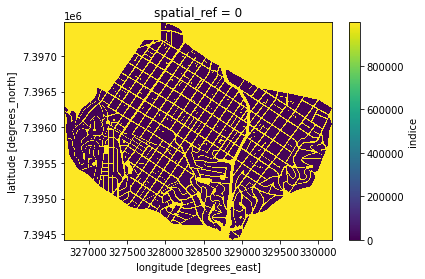

In [5]:
out_grid.indice.plot.imshow()